In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.feature import hog
from tqdm import tqdm
from joblib import Parallel, delayed
import os


In [2]:
def show_image_by_range(pixels, labels, start=0, end=1, img_size=28):
    """
        Show images in range from start to end.
    """
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    for i in range(start, end):
        plt.subplot((end - start) // 4 + 1, 4, i + 1)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(pixels_tmp[i, :, :, 0], cmap='gray')

    plt.show()

def show_image_by_condition(pixels, labels, label_condition=None, numbers=24, img_size=28):
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    cnt = 0
    if label_condition is None:
        label_condition_set = set(np.unique(y_train))
    else:
        label_condition_set = set(label_condition)

    n_images = len(pixels)
    n_condition = len(label_condition_set)
    cached_label = set()
    while cnt < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
            cnt += 1
            cached_label.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, cnt)
            plt.axis('off')
            plt.title(labels[idx])
            plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

    plt.show()

In [3]:
dfTrain = pd.read_csv('archive/sign_mnist_train/sign_mnist_train.csv')
dfTest = pd.read_csv('archive/sign_mnist_test/sign_mnist_test.csv')
dfTrain.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [4]:
X_train = dfTrain.drop('label', axis=1).values
y_train = dfTrain['label'].values
X_test = dfTest.drop('label', axis=1).values
y_test = dfTest['label'].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27455, 784) (27455,) (7172, 784) (7172,)


In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train

array([[0.41960784, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607843,
        0.79215686],
       [0.60784314, 0.61568627, 0.61176471, ..., 0.40392157, 0.52941176,
        0.58431373],
       [0.73333333, 0.7372549 , 0.7372549 , ..., 0.76470588, 0.76078431,
        0.76470588],
       ...,
       [0.68235294, 0.68235294, 0.68235294, ..., 0.79215686, 0.78431373,
        0.78431373],
       [0.69411765, 0.70980392, 0.72156863, ..., 0.25098039, 0.34117647,
        0.36470588],
       [0.70196078, 0.70588235, 0.70588235, ..., 0.80392157, 0.81960784,
        0.84313725]])

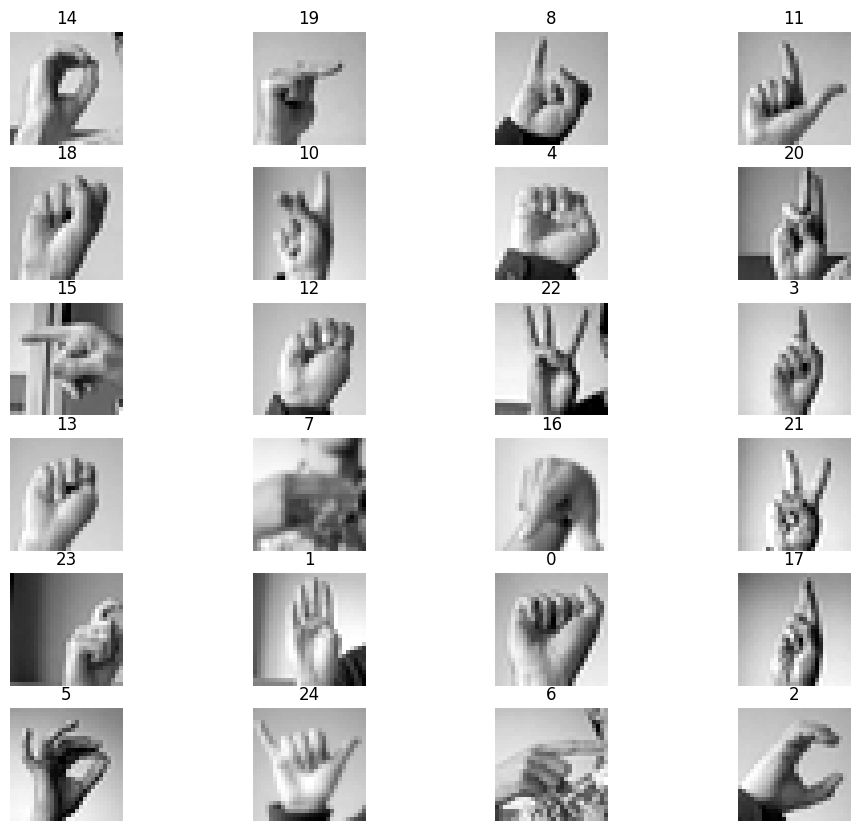

In [6]:
# Visualize images
show_image_by_condition(X_train, y_train, numbers=24)

In [7]:
def extract_hog(img, img_size=28, orientations=9, pixels_per_cell=(2,5), cells_per_block=(1, 1)):
    """
        Histogram of Oriented Gradients
    """
    fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)

    return fd

def call_parallel_extraction(images):
    """
        Process images parallelly
    """
    features = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(images))
    return np.array(features)

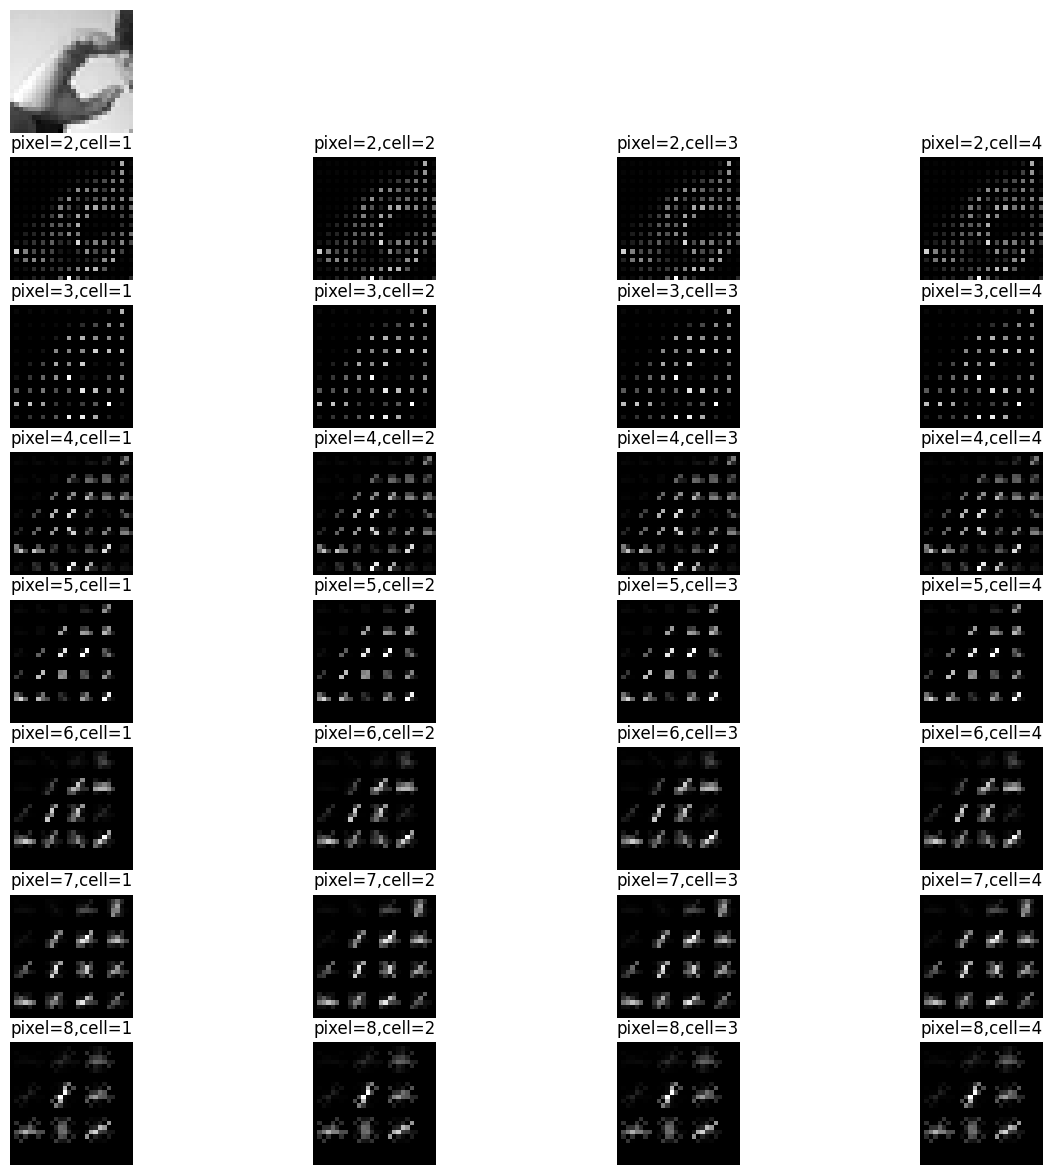

In [8]:
represent_index = 3
plt.figure(figsize=(15, 15))
plt.subplot(8, 4, 1)
plt.imshow(X_train[represent_index].reshape(28, 28), cmap='gray')
plt.axis('off')
cnt = 2
for n_pixel in range(2, 9):
    for n_cell in range(1, 5):
        _, represent_hog = hog(X_train[represent_index: 4].reshape((28, 28)), \
                               orientations=9, pixels_per_cell=(n_pixel, n_pixel), \
                               cells_per_block=(n_cell, n_cell), visualize=True)
        plt.subplot(8, 4, cnt + 3)
        cnt += 1
        plt.title('pixel=' + str(n_pixel) + ',cell=' + str(n_cell))
        plt.imshow(represent_hog, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
# Features extraction using HOG
X_train_hog = call_parallel_extraction(X_train)
X_test_hog = call_parallel_extraction(X_test)

100%|██████████| 7172/7172 [00:00<00:00, 27046.26it/s]


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score

svm_grid_search = SVC()
svm_grid_search.fit(X_train_hog, y_train)

# y_pred_svm = svm_grid_search.predict(X_test_hog)
# accuracy_svm = accuracy_score(y_test ,  y_pred_svm)
# accuracy_svm
# độ chính xác của tập train
y_pred_svm = svm_grid_search.predict(X_train_hog)
accuracy_svm = accuracy_score(y_train ,  y_pred_svm)
print(accuracy_svm)
# độ chính xác của tập test
y_pred_svm_ = svm_grid_search.predict(X_test_hog)
accuracy_svm_ = accuracy_score(y_test ,  y_pred_svm_)
print(accuracy_svm_)
print(f1_score(y_test, y_pred_svm_, average='weighted'))

1.0
0.9276352481873954
0.9293066005567533
